In [70]:
import numpy as np
import skimage
from skimage import data, util, filters
from skimage.color import rgb2gray
from skimage.morphology import disk, square
from skimage.util import img_as_ubyte
from skimage.metrics import normalized_root_mse
import matplotlib.pyplot as plt

In [72]:
original_image = img_as_ubyte(data.camera())

# Zadanie 1 - zaszumianie obrazów

In [75]:
def add_salt_pepper_noise(image, amount):
    noisy_image = img_as_ubyte(util.random_noise(image, mode='s&p', amount=amount))
    return noisy_image

sp_5 = add_salt_pepper_noise(original_image, 0.05)
sp_10 = add_salt_pepper_noise(original_image, 0.1)
sp_20 = add_salt_pepper_noise(original_image, 0.2)

In [77]:
def add_gaussian_noise(image, std_dev):
    noisy_image = img_as_ubyte(util.random_noise(image, mode='gaussian', var=std_dev**2))
    return noisy_image

gaussian_005 = add_gaussian_noise(original_image, 0.05)
gaussian_008 = add_gaussian_noise(original_image, 0.08)
gaussian_01 = add_gaussian_noise(original_image, 0.1)

In [79]:
def add_uniform_noise(image, h):
    mask = np.random.uniform(-h, h, image.shape)
    noisy_image = np.clip(image + mask, 0, 255).astype(np.uint8)
    return noisy_image

uniform_10 = add_uniform_noise(original_image, 10)
uniform_20 = add_uniform_noise(original_image, 20)
uniform_40 = add_uniform_noise(original_image, 40)

In [81]:
def calculate_nmse(original, noisy):
    return np.sum(np.square(original - noisy)) / np.sum(np.square(original))

nmse_values = [
    calculate_nmse(original_image, sp_5),
    calculate_nmse(original_image, sp_10),
    calculate_nmse(original_image, sp_20),
    calculate_nmse(original_image, gaussian_005),
    calculate_nmse(original_image, gaussian_008),
    calculate_nmse(original_image, gaussian_01),
    calculate_nmse(original_image, uniform_10),
    calculate_nmse(original_image, uniform_20),
    calculate_nmse(original_image, uniform_40)
]

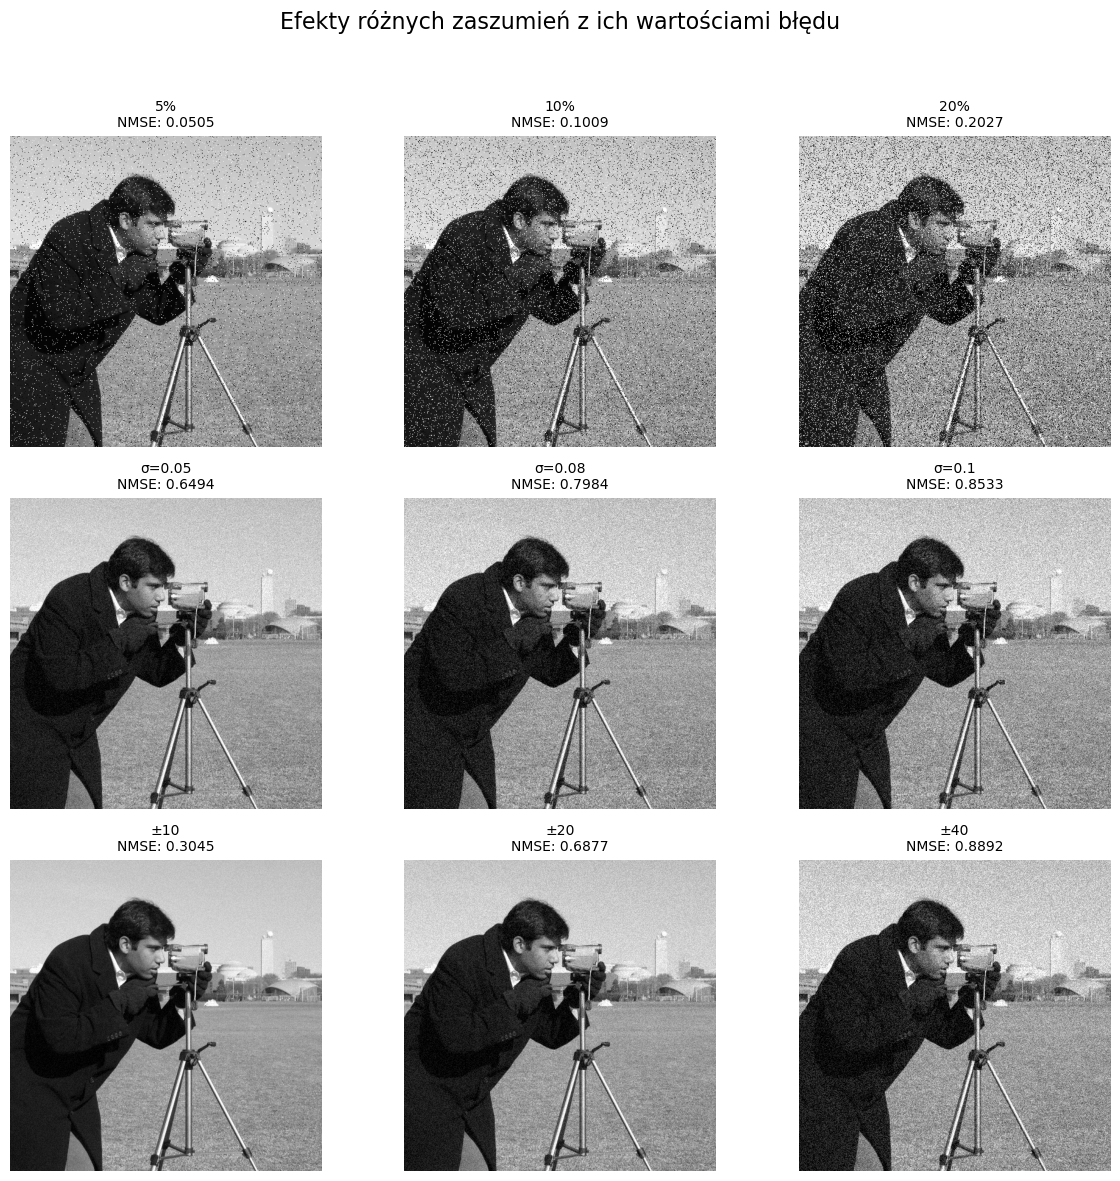

In [83]:
# Titles for each noise level
titles = ["5%", "10%", "20%", "σ=0.05", "σ=0.08", "σ=0.1", "±10", "±20", "±40"]

# Plot noisy images with NMSE as subtitles
fig, axes = plt.subplots(3, 3, figsize=(12, 12))
fig.suptitle("Efekty różnych zaszumień z ich wartościami błędu", fontsize=16)

# Display images and NMSE values as subtitles
noisy_images = [sp_5, sp_10, sp_20, gaussian_005, gaussian_008, gaussian_01, uniform_10, uniform_20, uniform_40]
for i, ax in enumerate(axes.flat):
    ax.imshow(noisy_images[i], cmap="gray")
    ax.set_title(f"{titles[i]}\nNMSE: {nmse_values[i]:.4f}", fontsize=10)
    ax.axis("off")

plt.tight_layout(rect=[0, 0, 1, 0.95]) 
plt.show()

# Zadanie 2 - usuwanie szumu

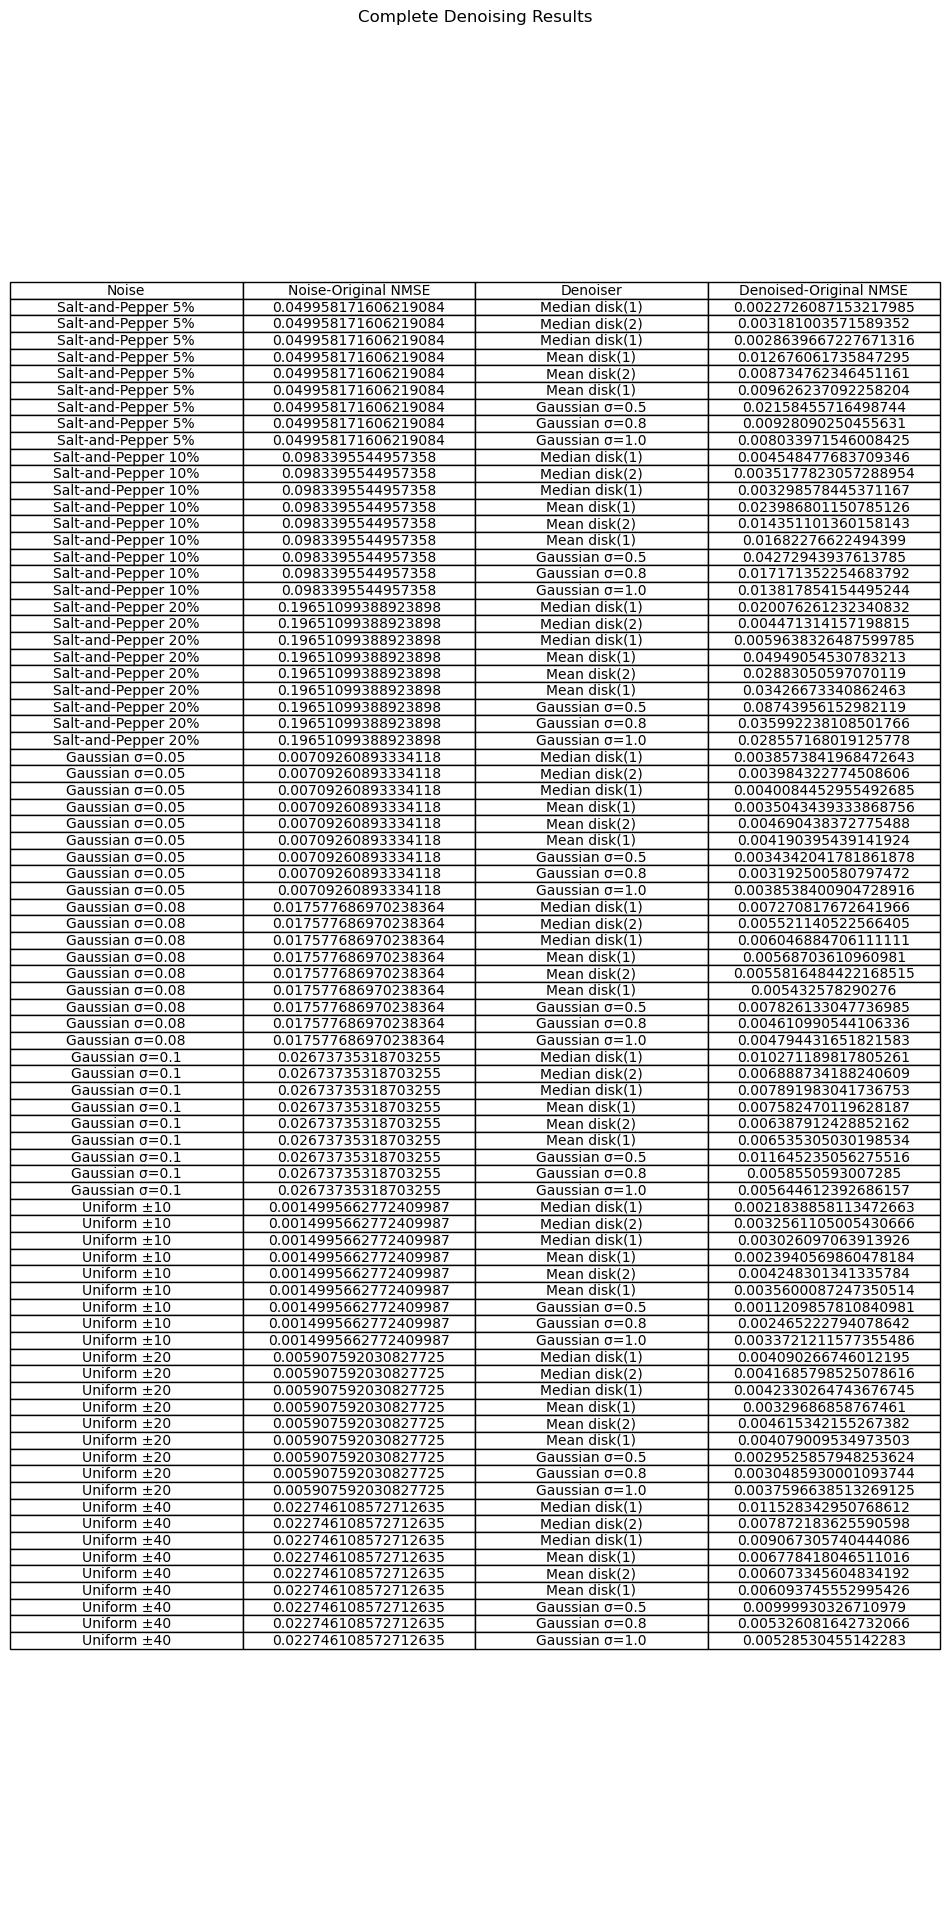

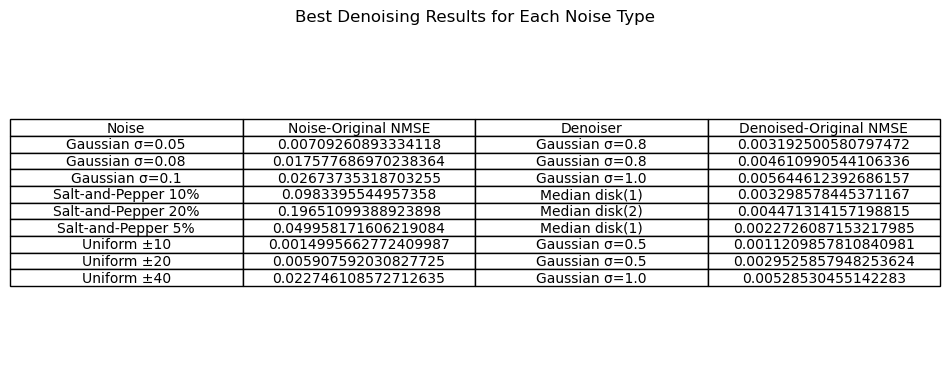

In [85]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage import filters, data
from skimage.morphology import disk, square
from skimage.util import img_as_ubyte, random_noise

original_image = data.camera()

def calculate_nmse(original, noisy):
    original, noisy = original.astype(np.float64), noisy.astype(np.float64)
    return np.sum((original - noisy) ** 2) / np.sum(original ** 2)

results = []

noisy_images = {
    "Salt-and-Pepper 5%": sp_5,
    "Salt-and-Pepper 10%": sp_10,
    "Salt-and-Pepper 20%": sp_20,
    "Gaussian σ=0.05": gaussian_005,
    "Gaussian σ=0.08": gaussian_008,
    "Gaussian σ=0.1": gaussian_01,
    "Uniform ±10": uniform_10,
    "Uniform ±20": uniform_20,
    "Uniform ±40": uniform_40,
}

for noise_name, noisy_image in noisy_images.items():
    nmse_noisy = calculate_nmse(original_image, noisy_image)
    
    for mask in [disk(1), disk(2), square(3)]:
        denoised_image = filters.median(noisy_image, mask)
        nmse_denoised = calculate_nmse(original_image, denoised_image)
        denoiser = f"Median disk({mask.shape[0]//2})" if mask.shape[0] % 2 == 1 else f"Median square({mask.shape[0]})"
        results.append([noise_name, nmse_noisy, denoiser, nmse_denoised])

    for mask in [disk(1), disk(2), square(3)]:
        denoised_image = filters.rank.mean(noisy_image, mask)
        nmse_denoised = calculate_nmse(original_image, denoised_image)
        denoiser = f"Mean disk({mask.shape[0]//2})" if mask.shape[0] % 2 == 1 else f"Mean square({mask.shape[0]})"
        results.append([noise_name, nmse_noisy, denoiser, nmse_denoised])

    for sigma in [0.5, 0.8, 1.0]:
        denoised_image = img_as_ubyte(filters.gaussian(noisy_image, sigma=sigma))
        nmse_denoised = calculate_nmse(original_image, denoised_image)
        denoiser = f"Gaussian σ={sigma}"
        results.append([noise_name, nmse_noisy, denoiser, nmse_denoised])

columns = ["Noise", "Noise-Original NMSE", "Denoiser", "Denoised-Original NMSE"]
df_results = pd.DataFrame(results, columns=columns)

best_results = df_results.sort_values(by="Denoised-Original NMSE").groupby("Noise").first().reset_index()

fig, ax = plt.subplots(figsize=(12, len(df_results) * 0.3))
ax.axis("off")
ax.table(cellText=df_results.values, colLabels=df_results.columns, cellLoc='center', loc='center')
plt.title("Complete Denoising Results")
plt.show()

fig, ax = plt.subplots(figsize=(12, len(best_results) * 0.5))
ax.axis("off")
ax.table(cellText=best_results.values, colLabels=best_results.columns, cellLoc='center', loc='center')
plt.title("Best Denoising Results for Each Noise Type")
plt.show()


# Zadanie 3 - zaszumianie obrazu szumem impulsowym

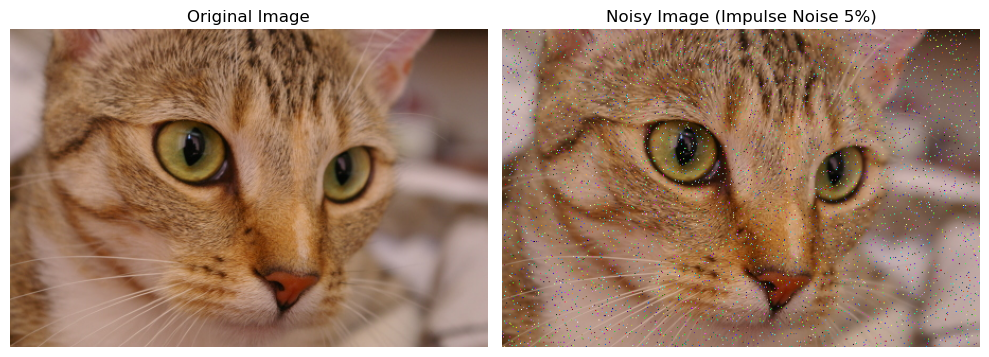

In [88]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import data
from skimage.util import img_as_float


def impulse_noise(image, p):
    noisy_image = np.copy(image)
    
    num_pixels = image.shape[0] * image.shape[1] * p // 100
    
    for _ in range(int(num_pixels)):
        x = np.random.randint(0, image.shape[1])
        y = np.random.randint(0, image.shape[0])

        R = np.random.randint(0, 256)
        G = np.random.randint(0, 256)
        B = np.random.randint(0, 256)

        noisy_image[y, x] = (R, G, B)
    
    return noisy_image

image = data.chelsea()


p = 5 # % of pixels to be altered
noisy_image = impulse_noise(image, p)


plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(image)
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title(f"Noisy Image (Impulse Noise {p}%)")
plt.imshow(noisy_image)
plt.axis("off")

plt.tight_layout()
plt.show()


# Zadanie 4 - NMSE dla obrazów RGB

Impulse Noise 2%: NMSE = 0.0206



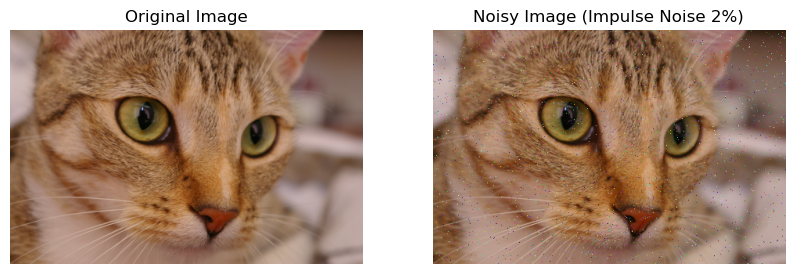

In [90]:
def calculate_nmse_RGB(original, noisy):
    return np.sum(np.square(original - noisy)) / np.sum(np.square(original))

p = 2
original_image = data.chelsea()
noisy_image = impulse_noise(original_image, p)
nmse_value = calculate_nmse_RGB(original_image, noisy_image)
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(original_image)
plt.axis("off")
plt.subplot(1, 2, 2)
plt.title(f"Noisy Image (Impulse Noise {p}%)")
plt.imshow(noisy_image)
plt.axis("off")

# Zadanie 5 


Impulse Noise 2%:
NMSE (Original vs Noisy): 0.0202
NMSE (Original vs Standard Median): 0.0022
NMSE (Original vs Vector Median): 0.0017


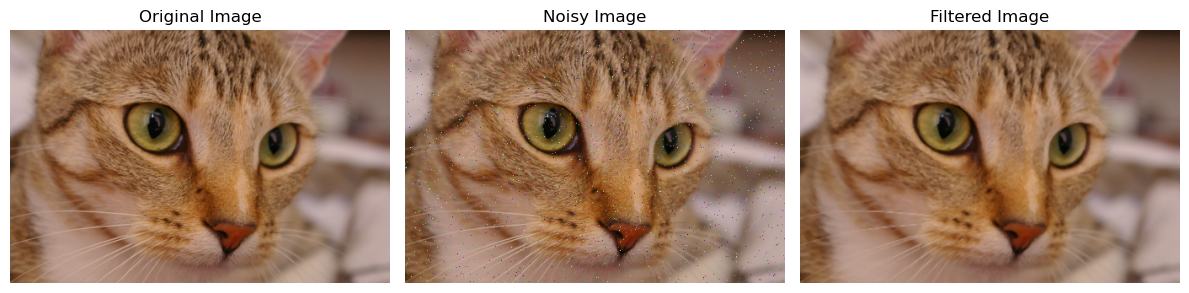


Impulse Noise 5%:
NMSE (Original vs Noisy): 0.0495
NMSE (Original vs Standard Median): 0.0023
NMSE (Original vs Vector Median): 0.0018


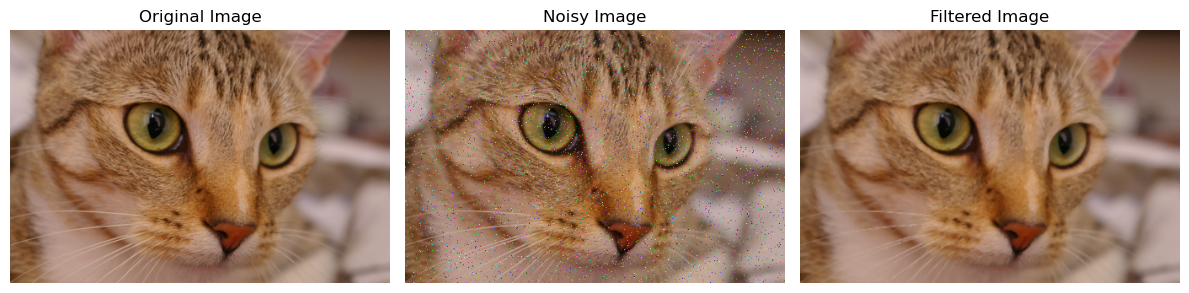


Impulse Noise 10%:
NMSE (Original vs Noisy): 0.0972
NMSE (Original vs Standard Median): 0.0025
NMSE (Original vs Vector Median): 0.0020


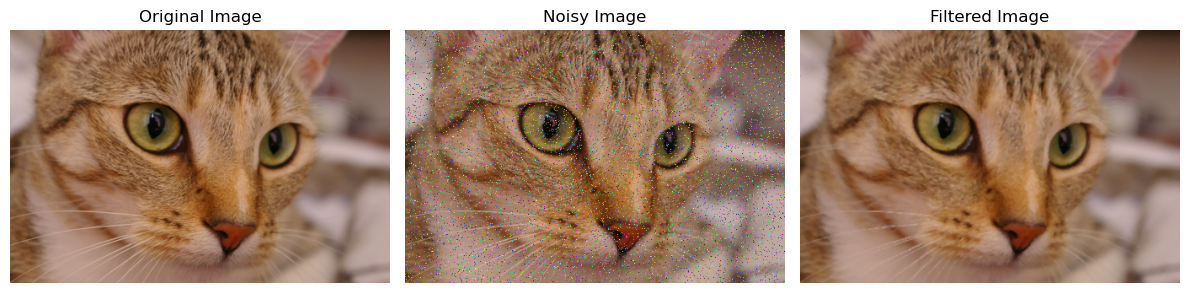

In [93]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import color
from skimage import filters, util, data
from skimage.morphology import disk

def vector_median_filter(image, window_size=3):
    pad_width = window_size // 2
    padded_image = np.pad(image, ((pad_width, pad_width), (pad_width, pad_width), (0, 0)), mode='edge')

    filtered_image = np.zeros_like(image)
    for y in range(image.shape[0]):
        for x in range(image.shape[1]):
            window = padded_image[y:y + window_size, x:x + window_size]
            for channel in range(3):
                filtered_image[y, x, channel] = np.median(window[..., channel])

    return filtered_image



def apply_filters_and_calculate_nmse(original_image, noisy_image):
    results = []

    median_filtered_image = np.zeros_like(noisy_image)

    for channel in range(noisy_image.shape[2]):
        median_filtered_image[:, :, channel] = filters.median(noisy_image[:, :, channel], disk(2))

    nmse_median = calculate_nmse(original_image, median_filtered_image)


    vmf_filtered_image = vector_median_filter(noisy_image, window_size=3) 
    nmse_vmf = calculate_nmse(original_image, vmf_filtered_image)

    results.append(['Standard Median', nmse_median])
    results.append(['Vector Median', nmse_vmf])

    return results, median_filtered_image, vmf_filtered_image



original_image = data.chelsea()  
noise_levels = [2, 5, 10]  

for p in noise_levels:
    noisy_image = impulse_noise(original_image, p)  

    nmse_noisy = calculate_nmse_RGB(original_image, noisy_image)


    results, median_filtered_image, vmf_filtered_image = apply_filters_and_calculate_nmse(original_image, noisy_image)

    print(f"\nImpulse Noise {p}%:")
    print(f"NMSE (Original vs Noisy): {nmse_noisy:.4f}")
    for filter_type, nmse in results:
        print(f"NMSE (Original vs {filter_type}): {nmse:.4f}")

    images = [original_image, noisy_image, vmf_filtered_image]
    titles = ["Original Image", "Noisy Image", "Filtered Image"]
    
    # Create a figure with subplots in a single row
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    
    # Iterate over images, titles, and axes to display each with a title
    for ax, image, title in zip(axes, images, titles):
        ax.imshow(image)
        ax.set_title(title)
        ax.axis("off")  # Hide the axes
    
    # Display the plot
    plt.tight_layout()
    plt.show()